In [2]:
import numpy as np 
import pandas as pd 
import nltk
import os
import gensim, logging, os, re, string, tensorflow
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from gensim.utils import simple_preprocess
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
nltk.download('stopwords')
STOP_WORDS = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
scifi1=pd.read_csv("/floyd/home/Data/scifi1.csv", names=['Body'], header=0)



In [7]:
def clean_docs(doc1):
    doc1['Body'] = doc1['Body'].replace(r'\n',' ', regex=True)
    doc1['Body'] = doc1['Body'].str.replace('<[^<]+?>', '')
    return doc1


In [8]:
scifi1 = clean_docs(scifi1)

In [9]:
all_data = scifi1

In [10]:
all_data.Body = all_data.Body.astype(str)
all_data = all_data.sample(frac=1)

In [11]:
def clean_doc(doc):
    """
    Cleaning a document by several methods
    """

    # Lowercase
    doc = doc.lower()
    # Remove numbers
    doc = re.sub(r"[0-9]+", "", doc)
    # Split in tokens
    tokens = doc.split()
    # Remove punctuation
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    # Tokens with less then two characters will be ignored
    tokens = [word for word in tokens if len(word) > 1]
    
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return ' '.join(tokens)

In [12]:
documents = list()
tokenize  = lambda x: simple_preprocess(x)

for text in all_data.Body:
    text = clean_doc(text)
    documents.append(tokenize(text))


In [13]:
model = gensim.models.Word2Vec(documents, size=100, window=20, min_count=200, workers=4)

In [14]:
keys = ['stargate', 'palpatine', 'trek', 'picard', 'marvel', 'batman', 
        'enterprise', 'vader', 'hulk', 'starfleet', 'guardians']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [15]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

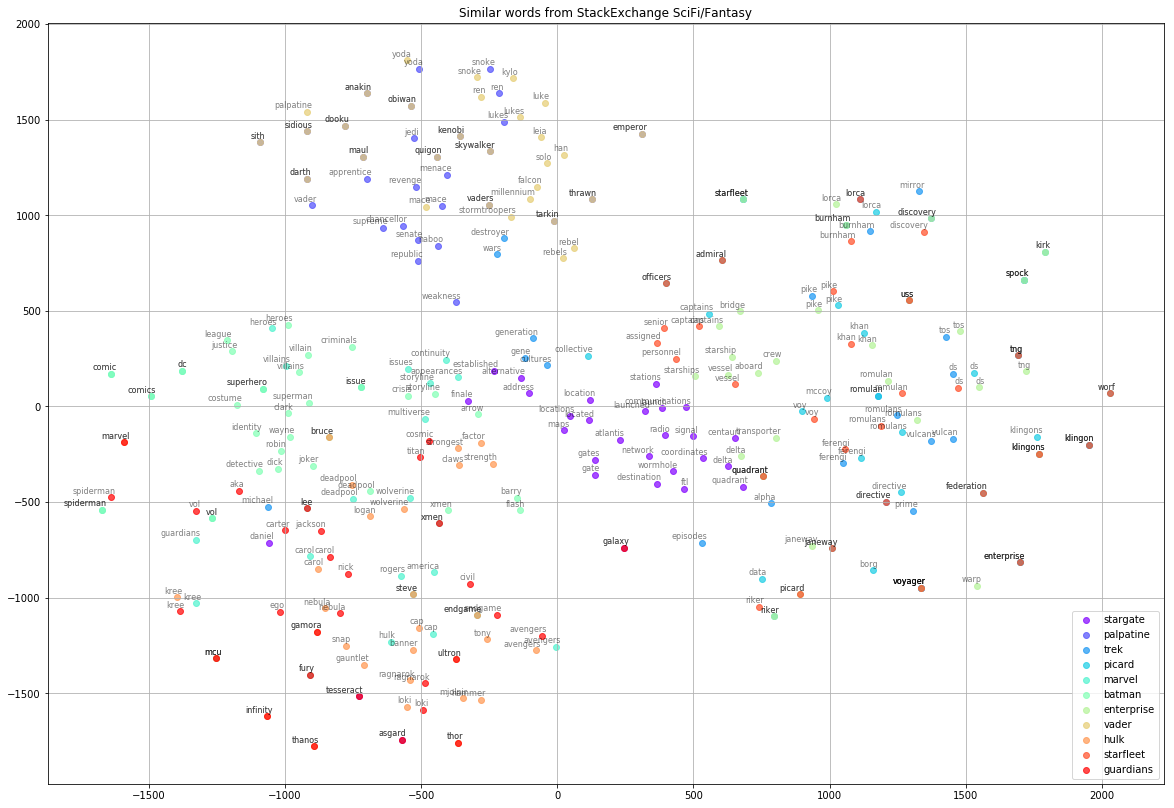

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm



def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(20, 14))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from StackExchange SciFi/Fantasy', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')